# Monte Carlo Nullpoint Approach - Code Description

This is the central code for looking at nullpoints under a Jupyter Notebooks framework

This is the python script for replicating the Bi,Spencer 2D stabilization technique with the intention of varying TI for Eq.3 to observe the TI related nullpoint - this code has the potential to look at a histogram for each TI value or to look at the standard deviation across the population for a range of TI values

# Import Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
# import mpld3
# mpld3.enable_notebook()

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Set Options

In [2]:
#Initial Options
histPlot = False
stdPlot = True
cNPlot = True
denPlot = True      #Plot all estimated signals against the true signal 

# Initialize Parameters and Arrays

In [3]:
#Assumed echo time points
tdata = np.arange(8, 512, 8) #ms units

######All Fixed parameters for code
#Parameters held constant
c1 = 0.3
c2 = 0.7
T21 = 100
T22 = 45
T11 = 600
T12 = 1200

realParams = np.array([c1, c2, T21, T22])

#Information determing TI range
bothTI = True
TI_numPoints = 31
TI_betPoints = 5
TI_lb = 0.8
TI_ub = 1.2
assert(TI_ub>TI_lb)

#Parameters that dictate process related features
iterCount = 10000 #number of iterations that curveFit is applied
SNR = 1000

#Preparing TI array to loop through
alpha_array = np.linspace(TI_lb,TI_ub,TI_numPoints)
TI1star = np.log(2)*(T11)
TI1_array = alpha_array*TI1star

TI2star = np.log(2)*T12
TI2_array = alpha_array*TI2star

bet_array = np.linspace(TI1_array[np.size(TI1_array)-1],TI2_array[0],TI_betPoints+2)
bet_array = bet_array[1:np.size(bet_array)-1]
assert(np.size(bet_array)==TI_betPoints)

if bothTI:
    TI_array = [*TI1_array, *bet_array, *TI2_array]
    betFill = np.zeros(TI_betPoints)
    alpha_array = [*alpha_array, *betFill, *alpha_array]
else:
    TI_array = TI1_array

#Initializing all the storage matrices
#Storing all strings associated with titles
ParamTitle = ['c1', 'c2', 'T21', 'T22']
MonoTitle = ['d', 'T2']
AllParamTitle = ['c1','c2','T11','T12','T21','T22']
dTitle = ['d1', 'd2', ParamTitle[2], ParamTitle[3]]

round_Params = [round(num, 2) for num in realParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle)

#Initializing where all parameter values are stored
paramStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle)])
paramStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(MonoTitle)])
avgPStore = np.zeros([np.size(TI_array), np.size(ParamTitle)])

#Storing all the estimated signals for each iteration and TI array
sigStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(tdata)])
sigStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(tdata)])

SNRStore = np.zeros([iterCount,np.size(TI_array)])

#All standard deviation of parameter values matrices
stdStore = np.zeros([np.size(TI_array),np.size(ParamTitle)])
dCoef_std = np.zeros([np.size(TI_array),np.size(dTitle)])
mono_std = np.zeros([np.size(TI_array),np.size(MonoTitle)])
std2Store = np.zeros([np.size(TI_array),np.size(ParamTitle)])

#All error related matrices
RSS_Store = np.zeros([np.size(TI_array),iterCount])
errStore = np.zeros([np.size(TI_array),iterCount])
RSS_Store_1E = np.zeros([np.size(TI_array),iterCount])
errStore_1E = np.zeros([np.size(TI_array),iterCount])

#Condition number related matrix
CNStore = np.zeros([np.size(TI_array), iterCount, np.size(AllParamTitle)])
avgCNStore = np.zeros([np.size(TI_array), np.size(AllParamTitle)])

# Define Functions

In [4]:
#Defining the function of interest
def biExp2D(tdata, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-tdata/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-tdata/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def monoExp2D(tdata, d, T2):
    return d*np.exp(-tdata/T2)

# #Pulled from Ryan Neff's code
def Jacobian_2D(TI, TE, T11, T12, c1, c2, T21, T22):
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dc1, dc2, dT11, dT12, dT21, dT22), axis = -1)
    return jacobian

# Build Curve Fitting Dataset

  0%|          | 0/67 [00:00<?, ?it/s]

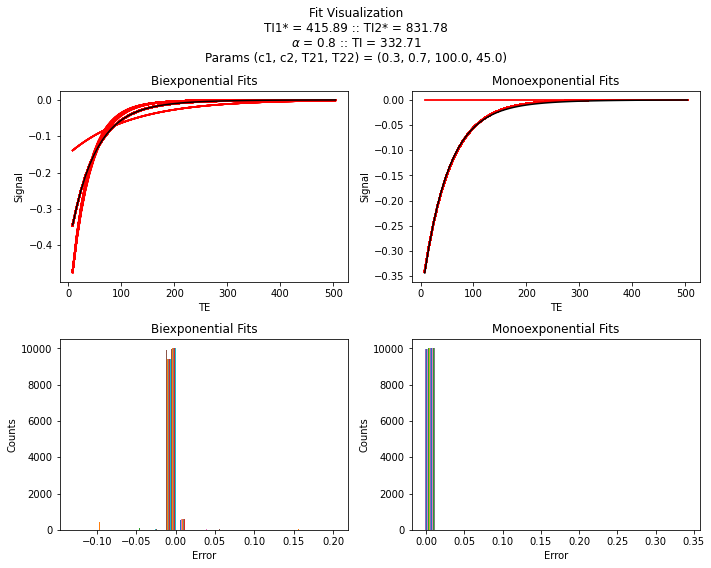

  1%|▏         | 1/67 [02:03<2:15:57, 123.60s/it]

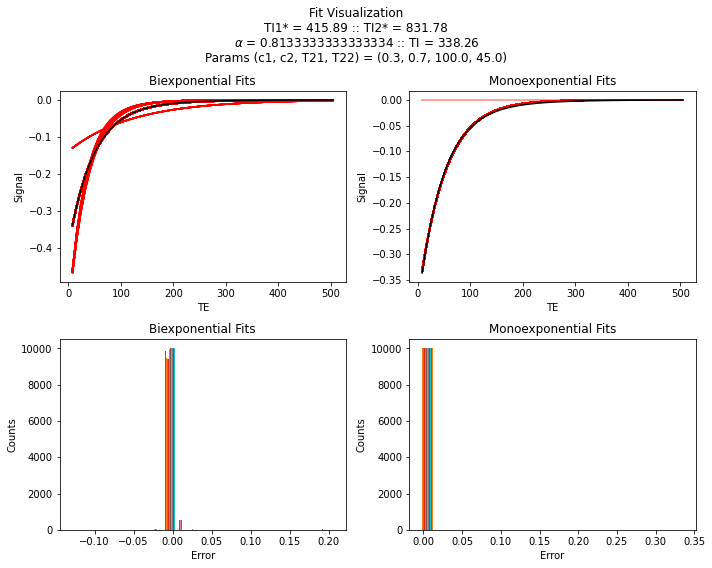

  3%|▎         | 2/67 [05:20<3:00:42, 166.80s/it]

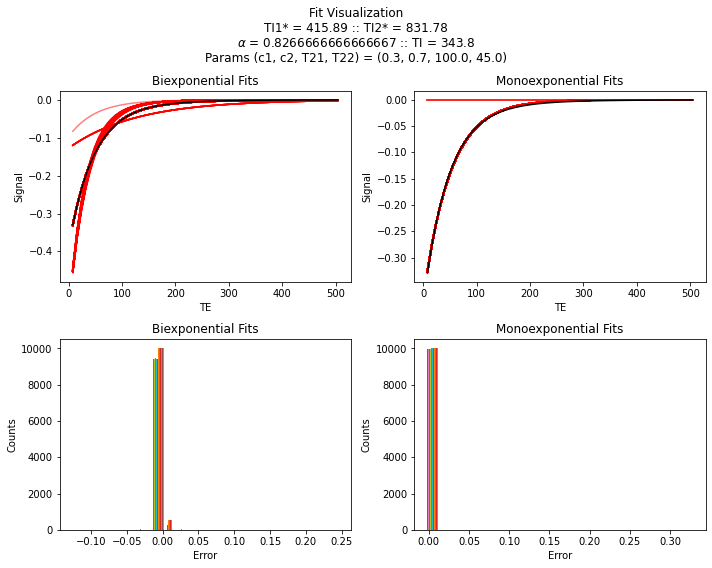

  4%|▍         | 3/67 [08:18<3:03:11, 171.75s/it]

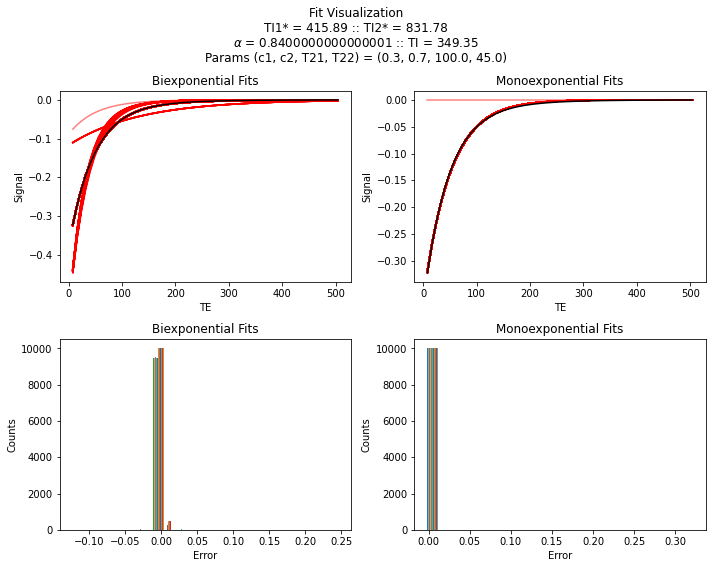

  6%|▌         | 4/67 [10:28<2:42:58, 155.21s/it]

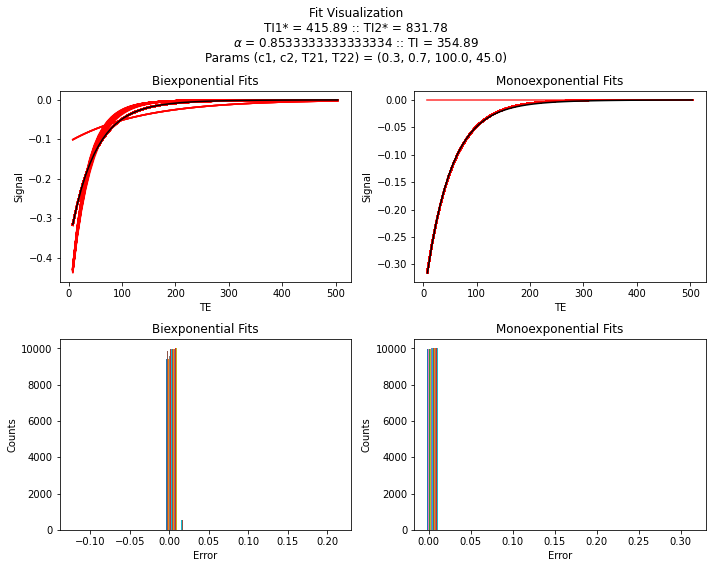

  7%|▋         | 5/67 [13:16<2:45:26, 160.11s/it]

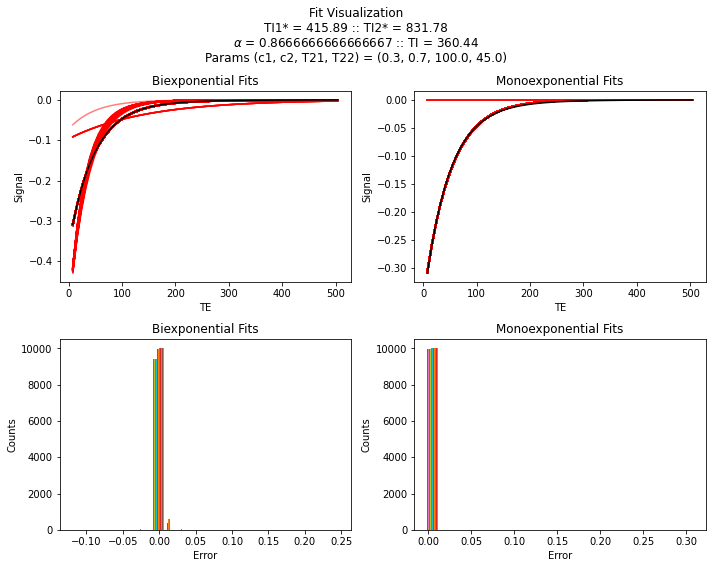

  9%|▉         | 6/67 [15:46<2:39:08, 156.52s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 6547


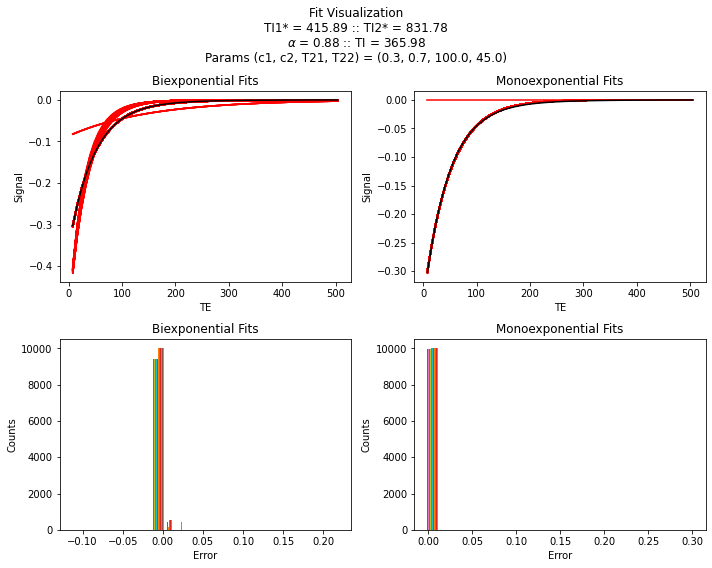

 10%|█         | 7/67 [18:24<2:36:54, 156.90s/it]

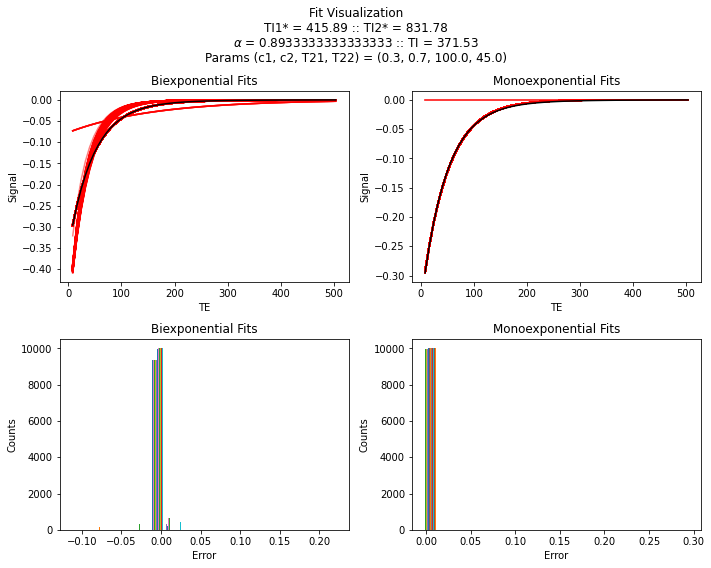

 12%|█▏        | 8/67 [21:03<2:35:02, 157.67s/it]

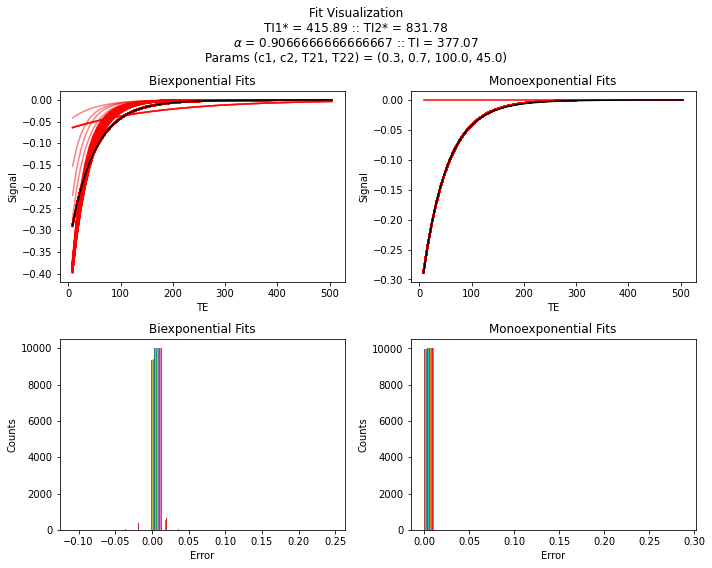

 13%|█▎        | 9/67 [23:33<2:30:00, 155.19s/it]

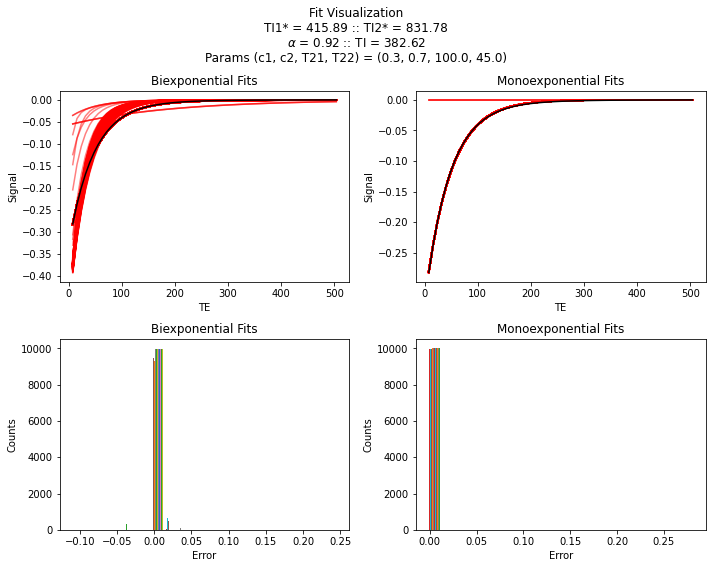

 15%|█▍        | 10/67 [27:05<2:44:01, 172.67s/it]

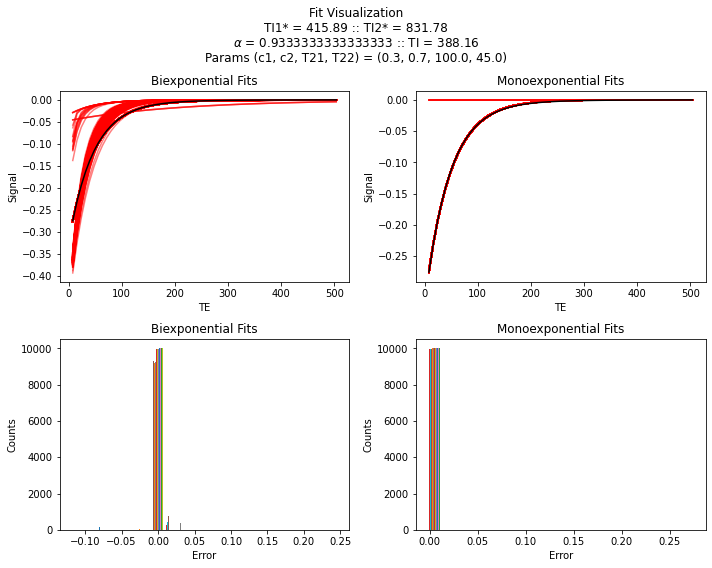

 16%|█▋        | 11/67 [31:01<2:59:28, 192.29s/it]

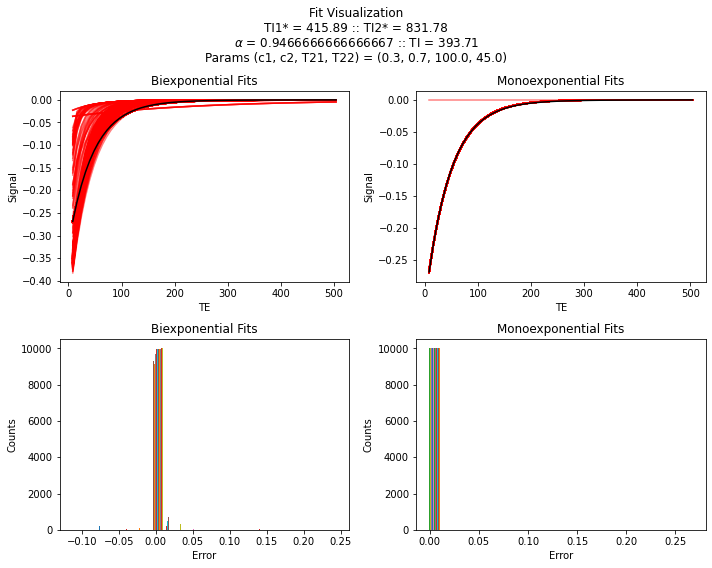

 18%|█▊        | 12/67 [34:06<2:54:03, 189.88s/it]

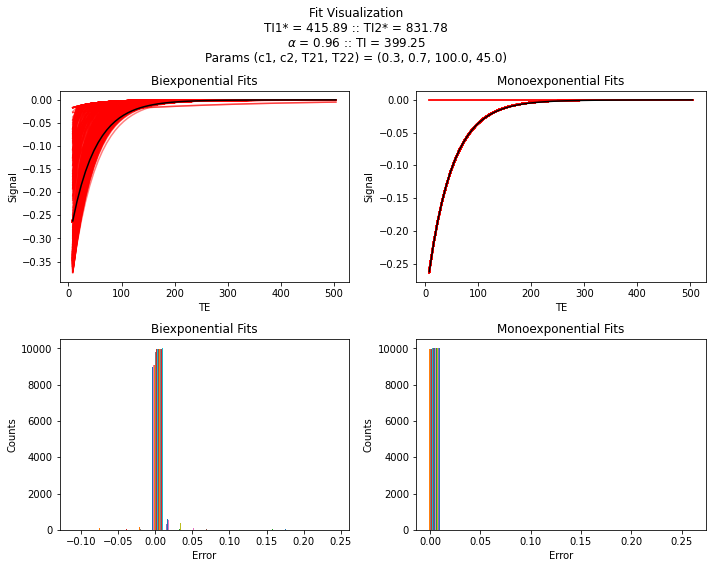

 19%|█▉        | 13/67 [38:00<3:03:07, 203.47s/it]

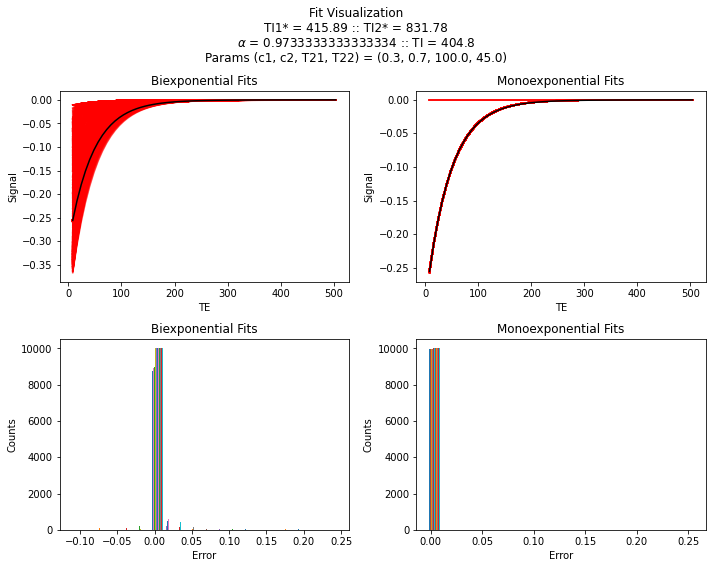

 21%|██        | 14/67 [41:29<3:01:08, 205.07s/it]

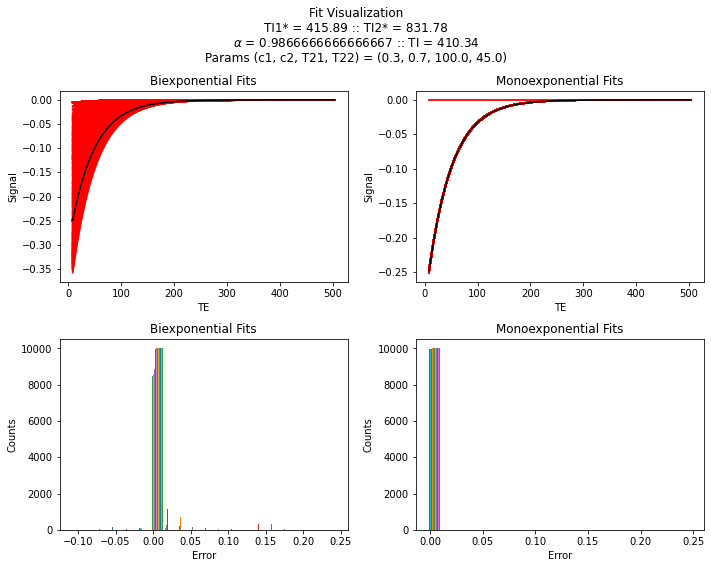

 22%|██▏       | 15/67 [44:37<2:53:18, 199.97s/it]

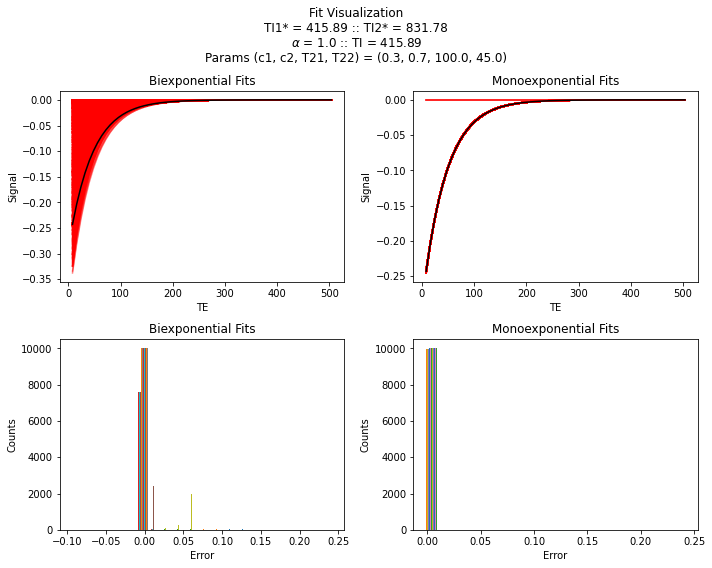

 24%|██▍       | 16/67 [50:28<3:28:33, 245.36s/it]

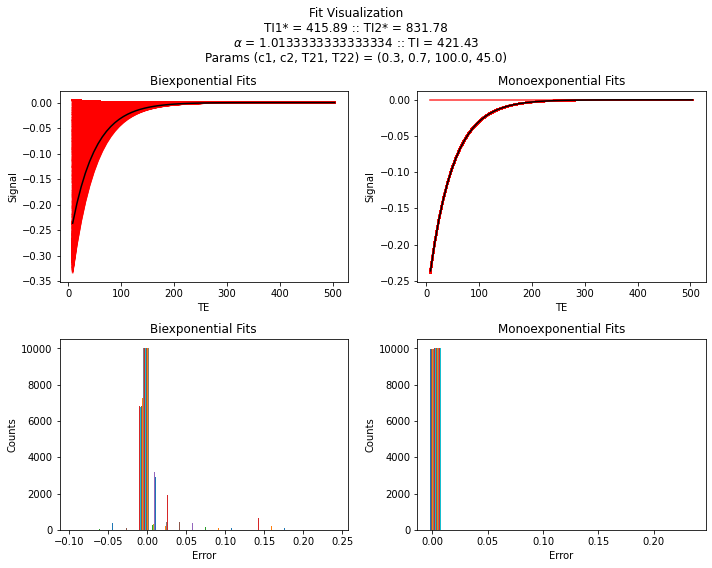

 25%|██▌       | 17/67 [56:52<3:59:05, 286.90s/it]

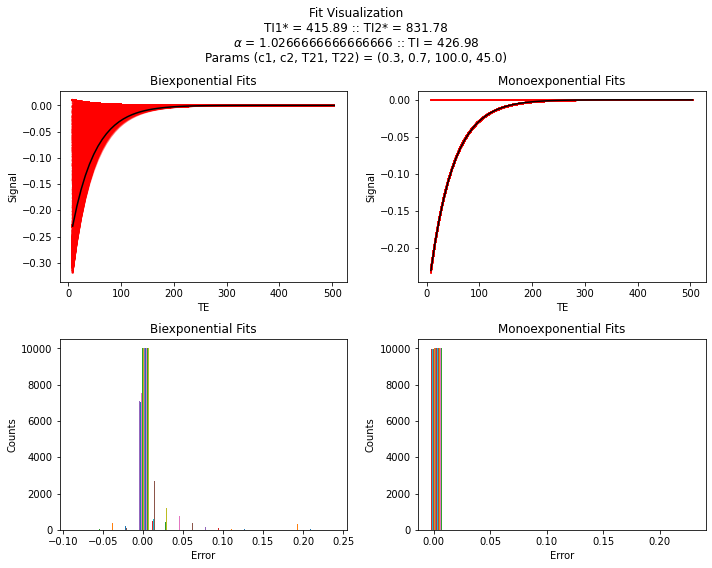

 27%|██▋       | 18/67 [1:01:43<3:55:22, 288.21s/it]

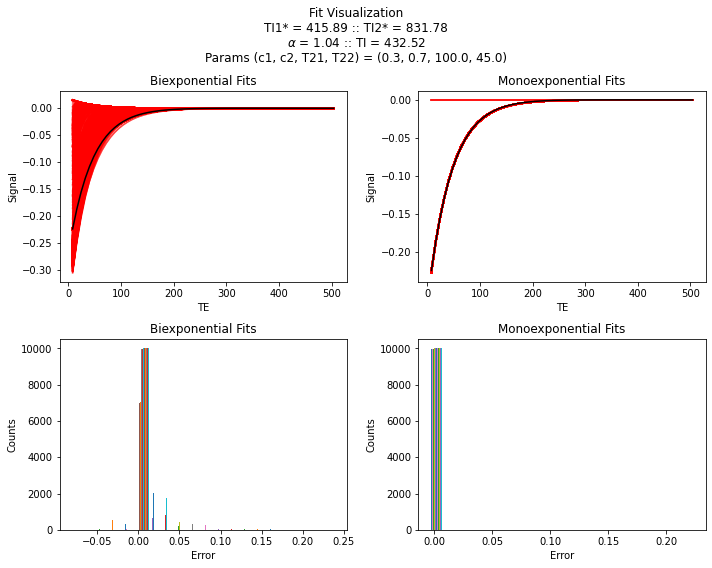

 28%|██▊       | 19/67 [1:06:38<3:52:16, 290.35s/it]

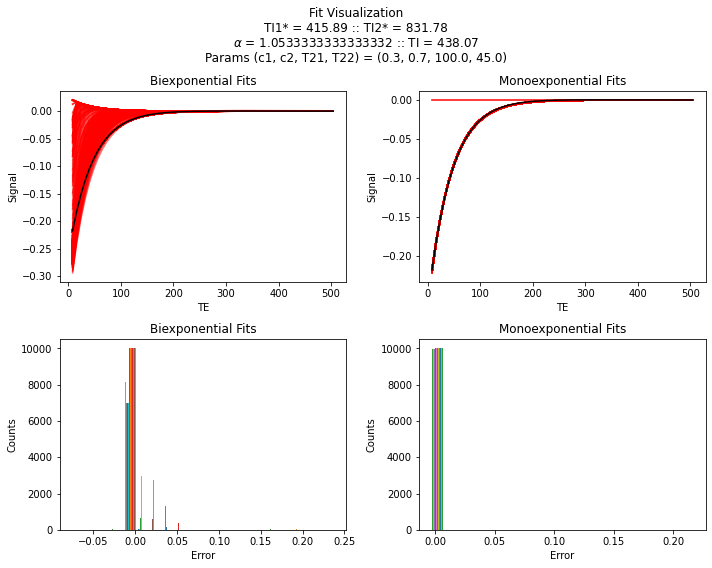

 30%|██▉       | 20/67 [1:11:35<3:49:04, 292.43s/it]

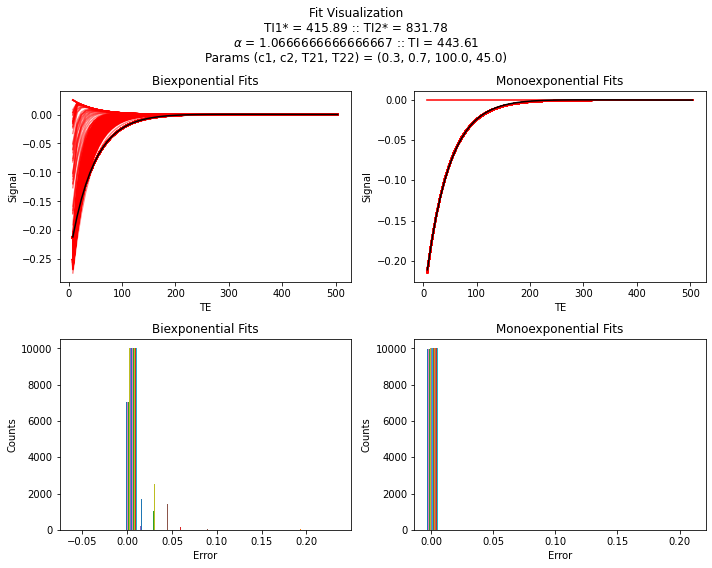

 31%|███▏      | 21/67 [1:17:13<3:54:34, 305.96s/it]

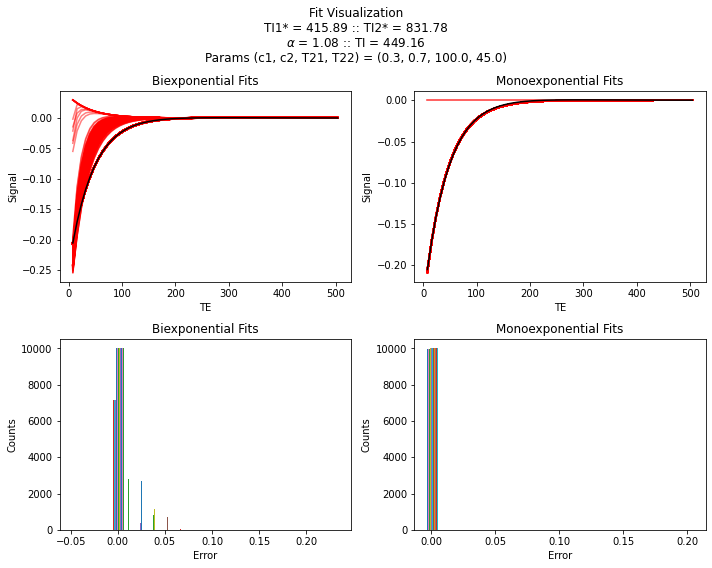

 33%|███▎      | 22/67 [1:23:36<4:06:49, 329.11s/it]

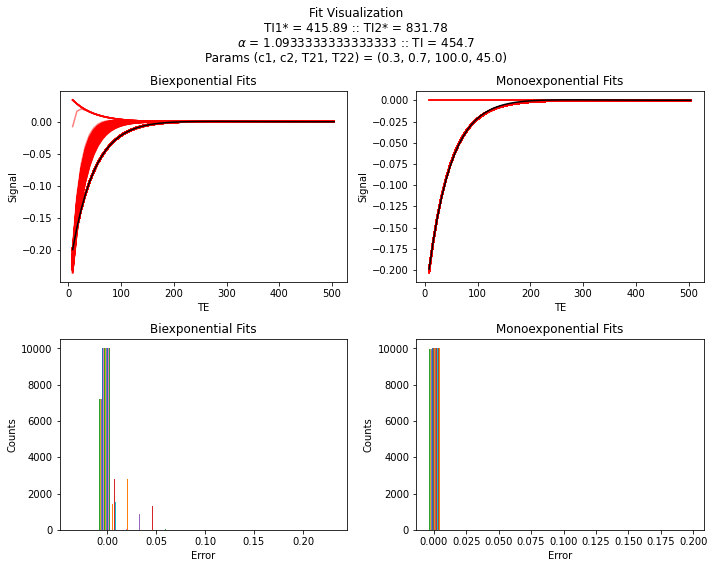

 34%|███▍      | 23/67 [1:30:44<4:23:11, 358.89s/it]

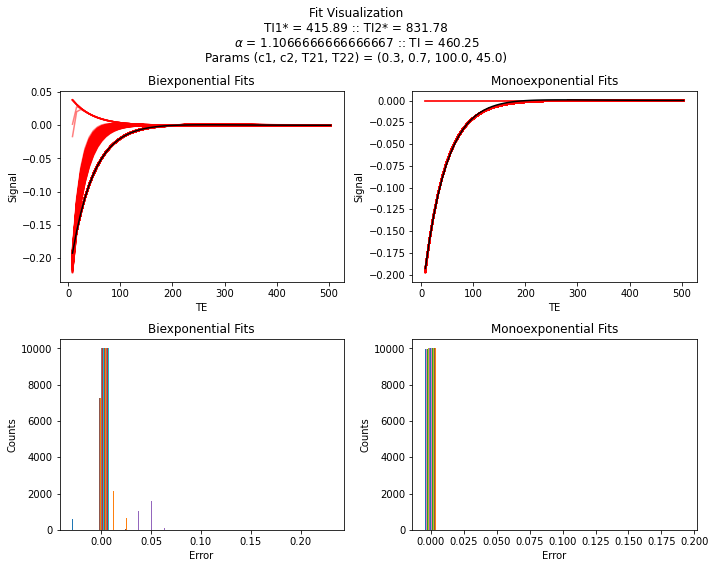

 36%|███▌      | 24/67 [1:37:58<4:33:16, 381.32s/it]

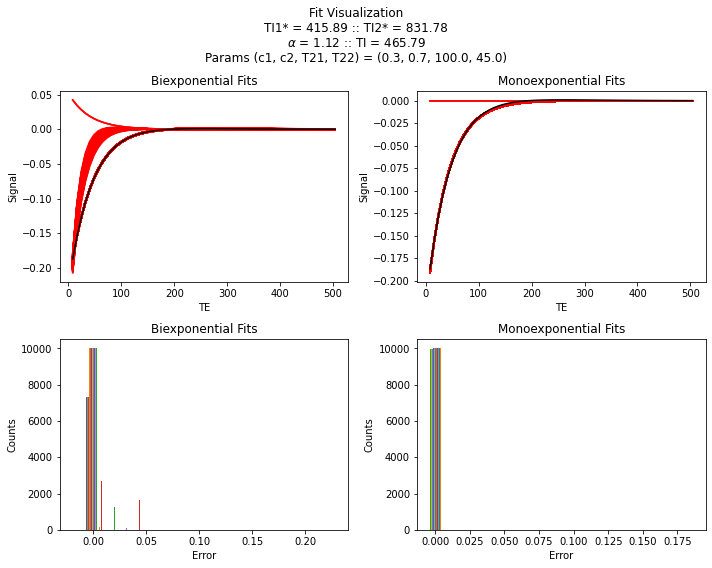

 37%|███▋      | 25/67 [1:45:46<4:45:03, 407.23s/it]

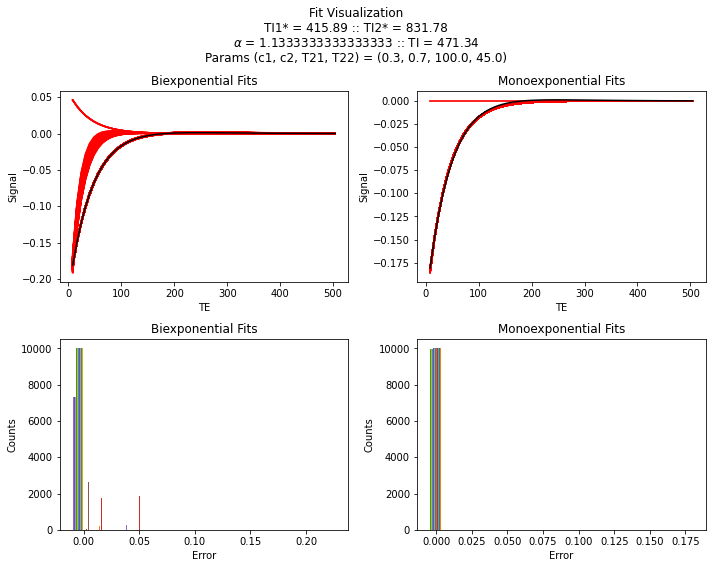

 39%|███▉      | 26/67 [1:52:46<4:41:00, 411.23s/it]

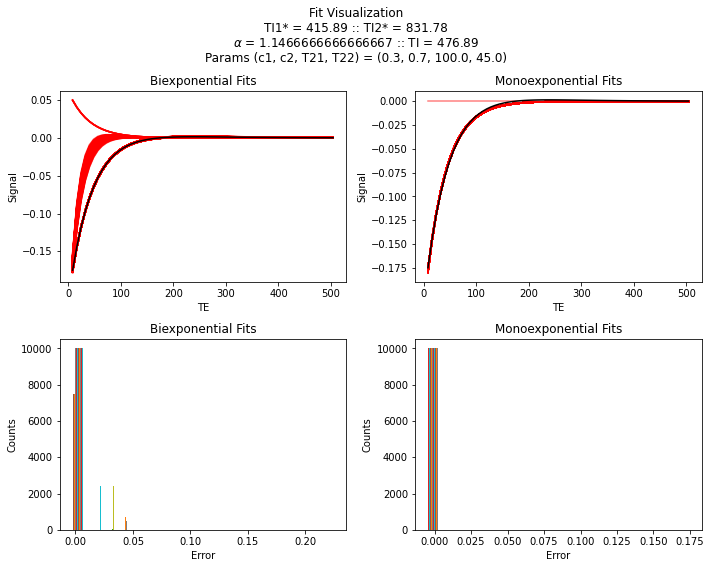

 40%|████      | 27/67 [1:59:40<4:34:35, 411.88s/it]

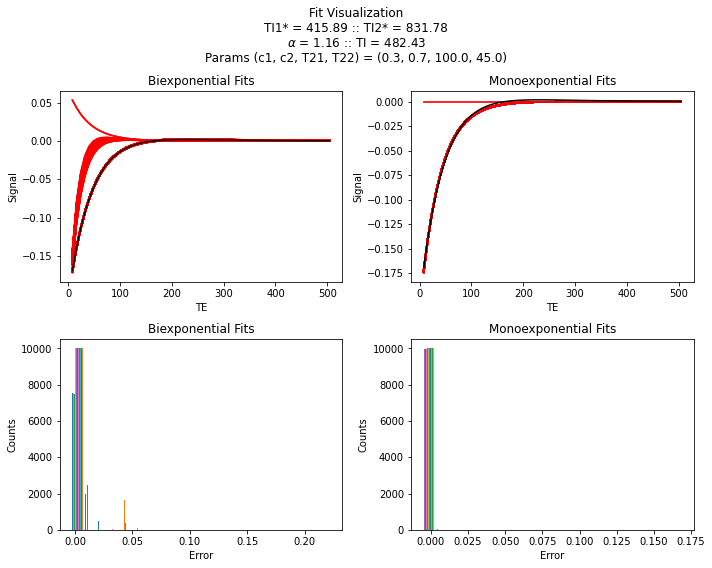

 42%|████▏     | 28/67 [2:06:51<4:31:32, 417.76s/it]

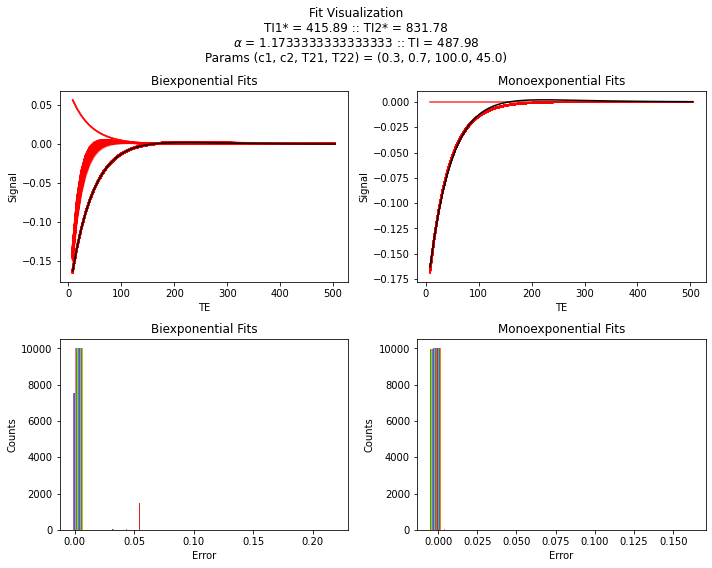

 43%|████▎     | 29/67 [2:15:47<4:47:05, 453.29s/it]

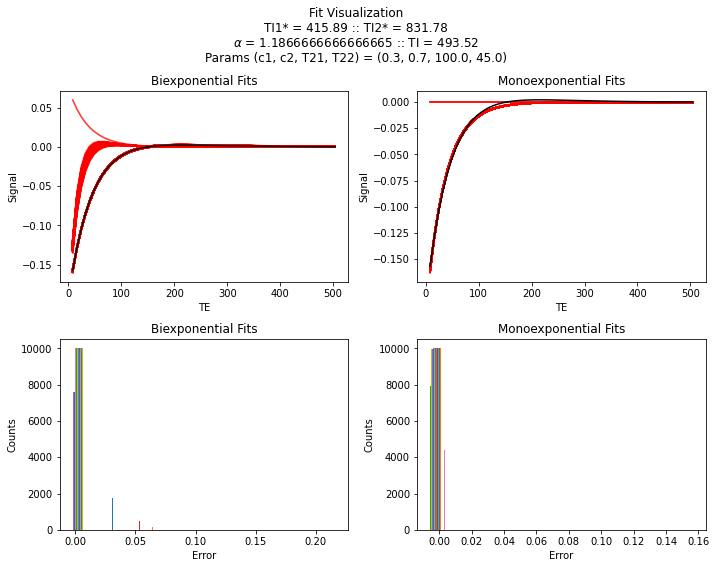

 45%|████▍     | 30/67 [2:24:01<4:46:55, 465.30s/it]

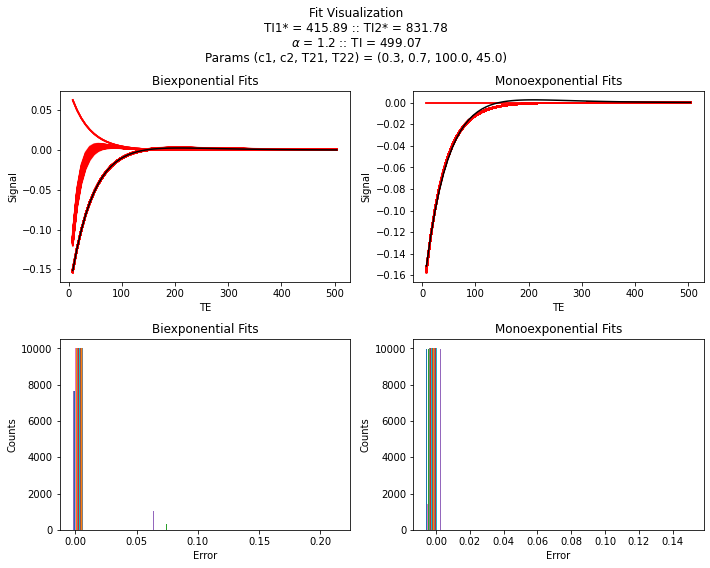

 46%|████▋     | 31/67 [2:31:02<4:31:12, 452.02s/it]

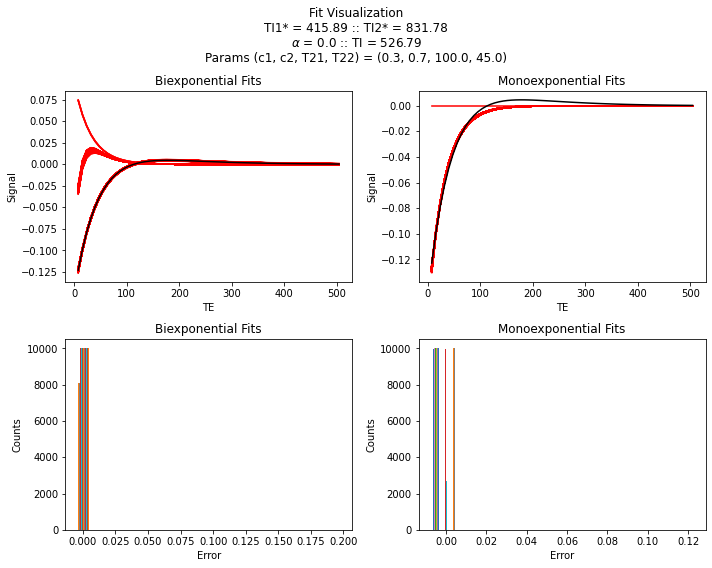

 48%|████▊     | 32/67 [2:37:50<4:16:03, 438.95s/it]

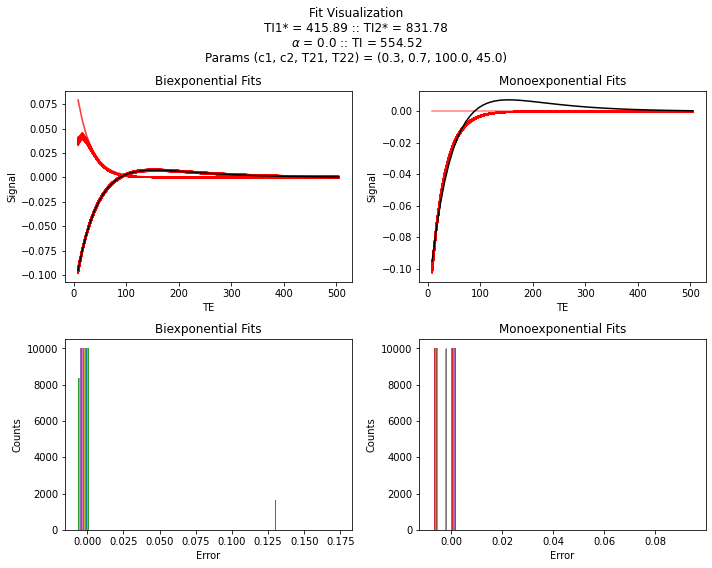

 49%|████▉     | 33/67 [2:45:21<4:10:45, 442.50s/it]

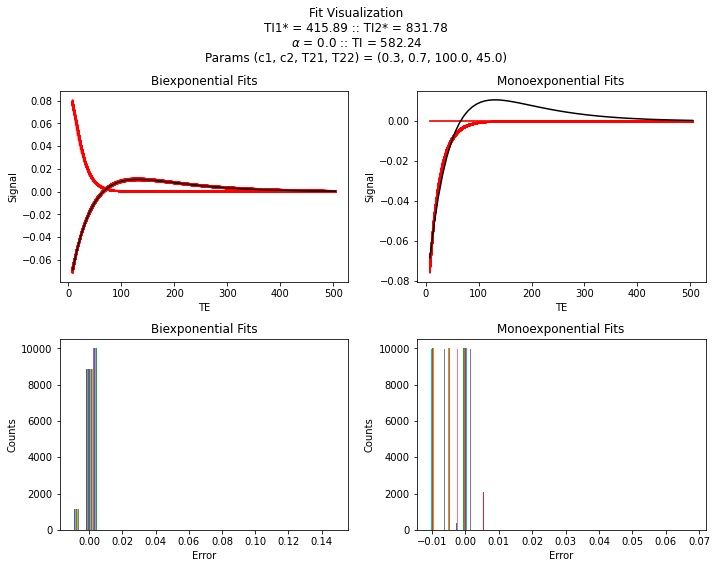

 51%|█████     | 34/67 [2:53:24<4:10:02, 454.64s/it]

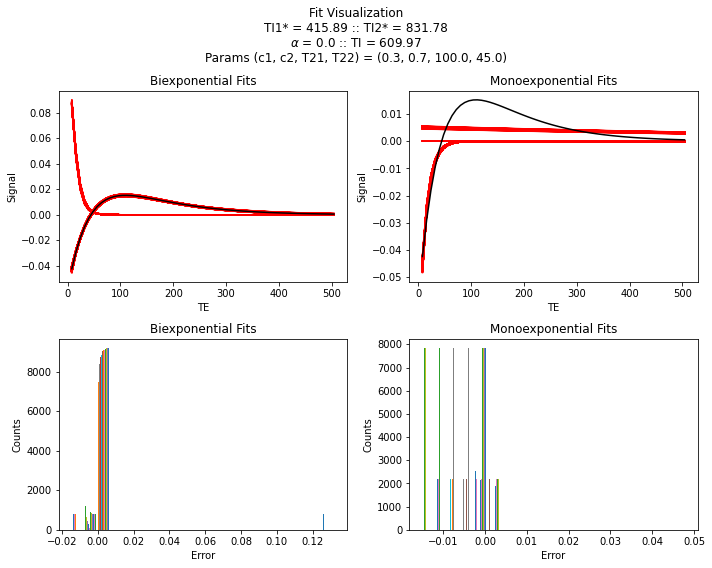

 52%|█████▏    | 35/67 [3:01:40<4:09:05, 467.05s/it]

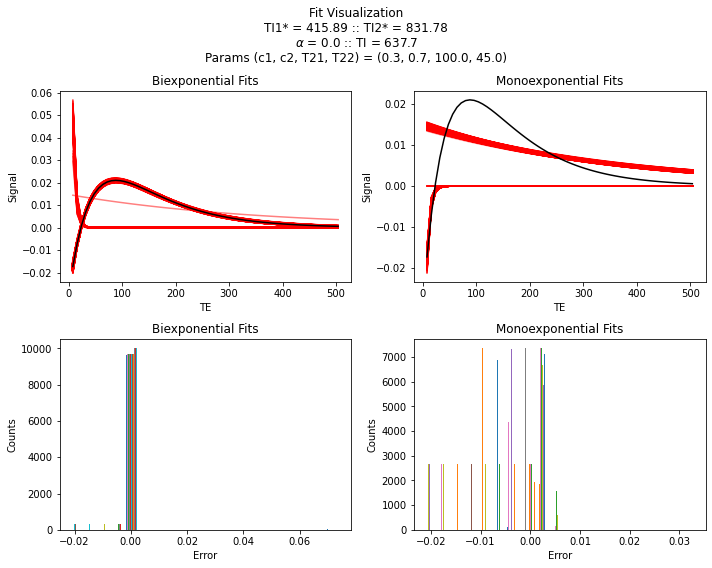

 54%|█████▎    | 36/67 [3:10:14<4:08:39, 481.28s/it]

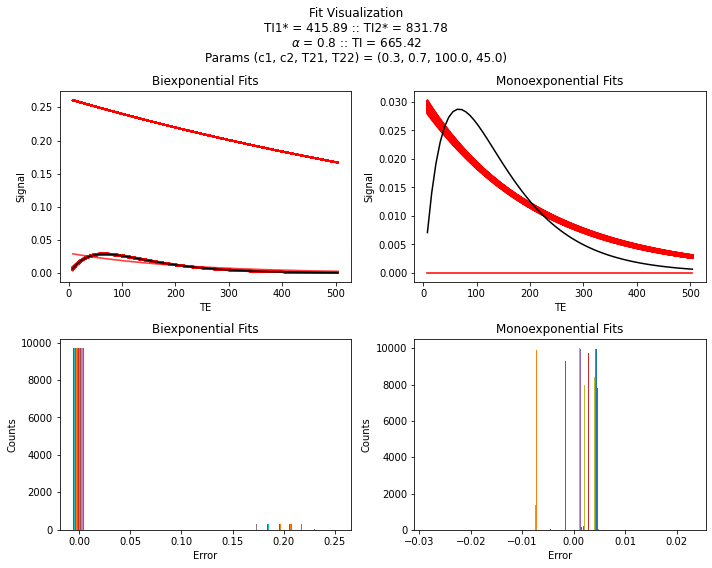

 55%|█████▌    | 37/67 [3:18:18<4:00:59, 481.98s/it]

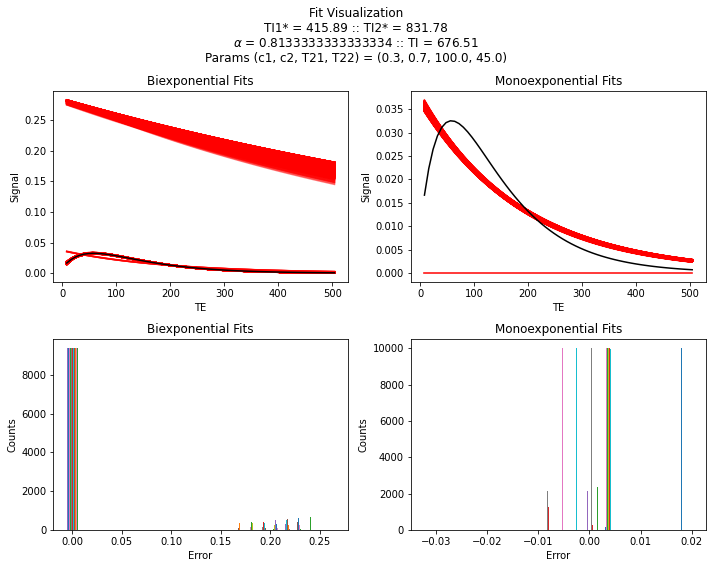

 57%|█████▋    | 38/67 [3:26:34<3:54:58, 486.17s/it]

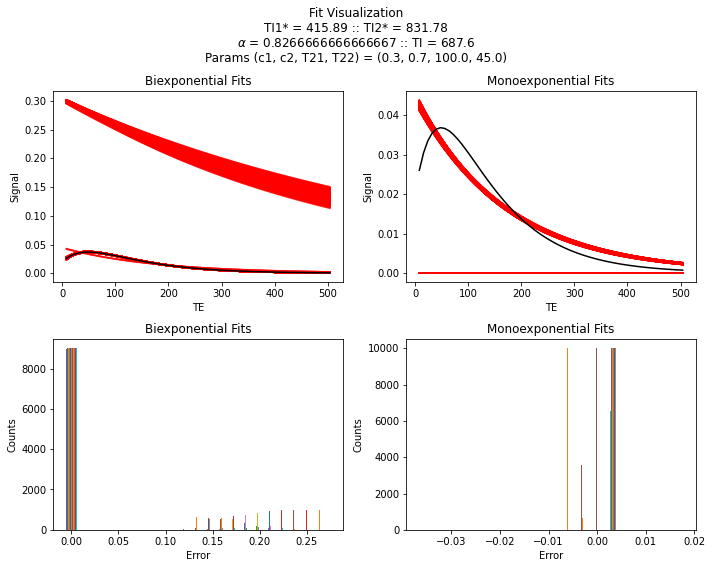

 58%|█████▊    | 39/67 [3:33:43<3:38:52, 469.01s/it]

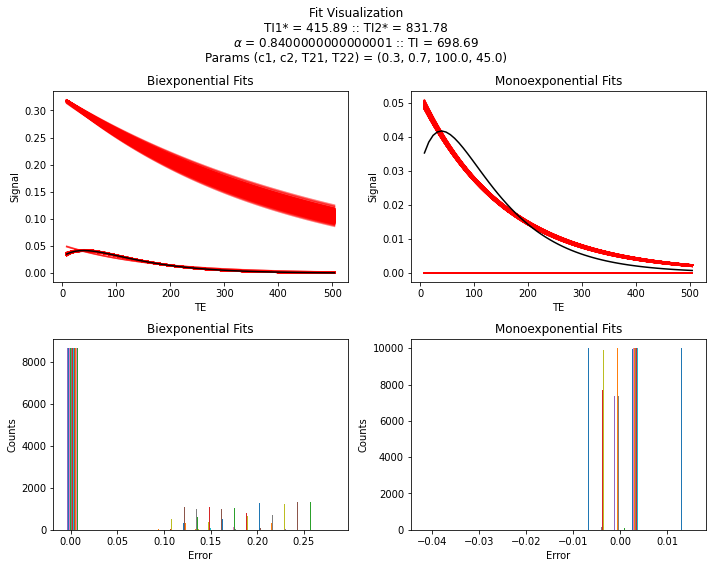

 60%|█████▉    | 40/67 [3:40:30<3:22:44, 450.55s/it]

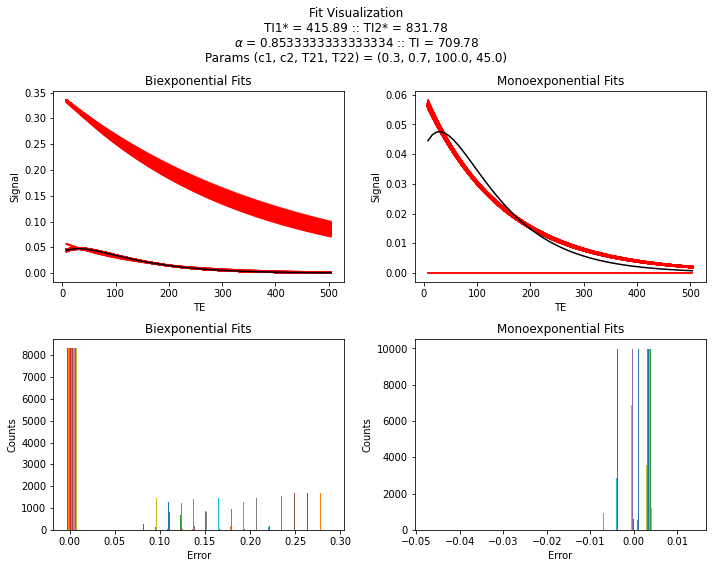

 61%|██████    | 41/67 [3:48:11<3:16:35, 453.65s/it]

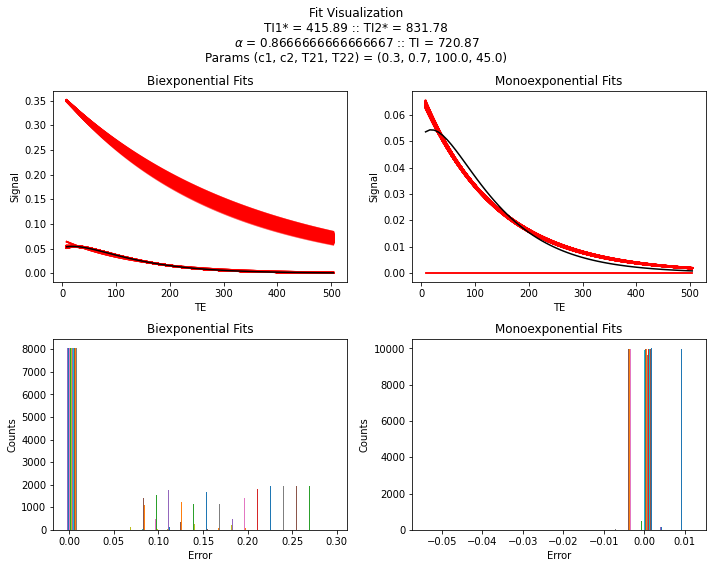

 63%|██████▎   | 42/67 [3:56:08<3:11:54, 460.58s/it]

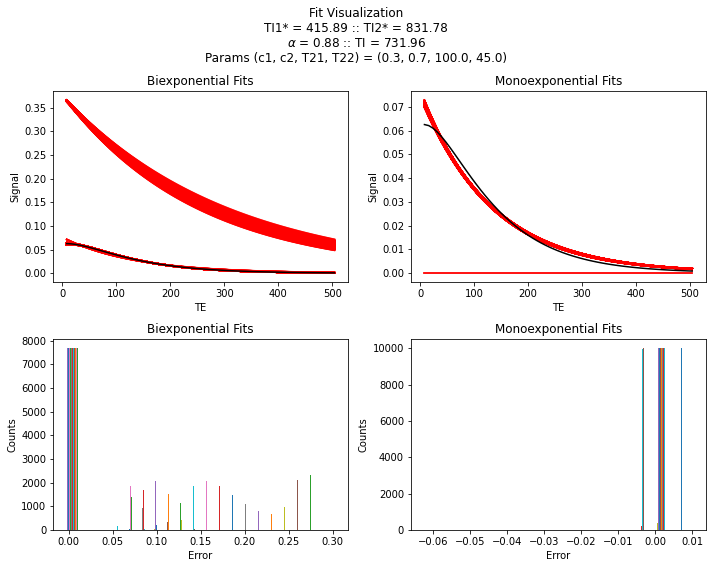

 64%|██████▍   | 43/67 [4:09:48<2:19:25, 348.58s/it]


KeyboardInterrupt: 

In [5]:
#Looping through all TI values in the TI_array
for k in trange(np.size(TI_array)):

    TI = TI_array[k]

    true_d1 = c1*(1-2*np.exp(-TI/T11))
    true_d2 = c2*(1-2*np.exp(-TI/T12))

    trueDat = biExp2D(tdata,TI,T11,T12,*realParams)
        
    i = 0
    #while loop so that if a lowest parameter value isn't found then we just do it again
    while i < iterCount:

        #Determining the noise and add noise to data
        noiseSigma = (c1+c2)/SNR
        noise = np.random.normal(0,noiseSigma,tdata.size)
        noiseDat = trueDat + noise

        #Experimental Signal to Noise Ratio Calculation
        mSNR = noiseDat/noise
        avgMSNR = np.absolute(np.mean(mSNR))
        SNRStore[i,k] = avgMSNR

        T2_bound = 1000

        lb = (0,0,0,0)
        ub = (1,1,T2_bound,T2_bound)
        init_c1 = np.random.uniform(lb[0],ub[0])
        init_c2 = np.random.uniform(init_c1,ub[1])
        init_T21 = np.random.randint(2,200)
        init_T22 = np.random.randint(1,init_T21)
        init_p = (init_c1,init_c2,init_T21,init_T22)

        lb_1E = (-1,0)
        ub_1E = (1,T2_bound)
        init_p_1E = (np.random.uniform(lb_1E[0],ub_1E[0]), np.random.randint(2,200))

        try:
            popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : biExp2D(t_dat,TI,T11,T12,p1,p2,p3,p4), tdata, noiseDat, p0 = init_p, bounds = [lb,ub])
            popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : monoExp2D(t_dat,p1,p2), tdata, noiseDat, p0 = init_p_1E, bounds = [lb_1E,ub_1E])
        except Exception as e:
            print(e)
            print("Rerunning this iteration = " + str(i))
            continue

        #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place
        if (popt_2E[3] > popt_2E[2]): #(popt_2E[0] > popt_2E[1] and popt_2E[3] > popt_2E[2]):
            p_hold = popt_2E[0]
            popt_2E[0] = popt_2E[1]
            popt_2E[1] = p_hold
            p_hold = popt_2E[2]
            popt_2E[2] = popt_2E[3]
            popt_2E[3] = p_hold

        paramStore_2E[k,i,:] = popt_2E
        paramStore_1E[k,i,:] = popt_1E

        #Calculate Condition Number
        B = Jacobian_2D(TI, tdata, T11, T12, *popt_2E) #TI, TE, T11, T12, c1, c2, T21, T22
        covP = np.dot(B.T,B)*noiseSigma**2

        CN_params = np.reshape(np.diag(covP),(1,-1))
        CNStore[k,i,:] = CN_params

        #Calculate Residual Sum of Squares (RSS) of 2E
        est_Sig = biExp2D(tdata,TI,T11,T12,*popt_2E)
        RSS_Store[k,i] = np.sum((trueDat - est_Sig)**2)
        errStore[k,i] = np.linalg.norm(trueDat - est_Sig, ord = 2)
        sigStore_2E[k,i,:] = est_Sig

        #Calculate Residual Sum of Squares (RSS) of 1E
        est_Sig_1E = monoExp2D(tdata,*popt_1E)
        RSS_Store_1E[k,i] = np.sum((trueDat - est_Sig_1E)**2)
        errStore_1E[k,i] = np.linalg.norm(trueDat - est_Sig_1E, ord = 2)
        sigStore_1E[k,i,:] = est_Sig_1E

        i += 1 #iteration step

    avgCNStore[k,:] = np.reshape(np.mean(CNStore[k,:,:], axis = 0),(1,-1))
    
    #Collect the standard deviation in parameter values
    stdStore[k,:] = np.std(paramStore_2E[k,:,:], axis = 0)

    avgPStore[k,:] = np.mean(paramStore_2E[k,:,:], axis = 0)

    std2Store[k,:] = np.var(paramStore_2E[k,:,:], axis = 0)**(1/2)

    # covParm = np.cov(paramStore)

    # cNPStore[k] = np.linalg.norm(covParm,ord='fro')*np.linalg.norm(np.linalg.inv(covParm),ord='fro')

    dCoef_conversion = np.array([(1-2*np.exp(-TI/T11)), (1-2*np.exp(-TI/T12)), 1, 1])
    dParams = realParams * dCoef_conversion
    dCoef_convertedMat = paramStore_2E[k,:,:] * dCoef_conversion
    dCoef_std[k,:] = np.std(dCoef_convertedMat, axis = 0)
    mono_std[k,:] = np.std(paramStore_1E[k,:,:], axis = 0)

    if histPlot:
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        for ii in range(2):

            #Get a good bin size
            binData = paramStore_2E[:,[2*ii,2*ii+1]]
            binData = np.reshape(binData,-1)
            binW = (np.max(binData) - np.min(binData))/12
            binW = float('%.1g' % binW) #converts everything to a single significant figure
            binMin = 10**(np.floor(np.log10(np.min(binData))))
            binArray = np.arange(binMin, np.max(binData) + binW, binW)

            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramStore_2E[:,2*ii], bins=binArray, color='b', label = ParamTitle[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramStore_2E[:,2*ii+1], bins=binArray, color='g', label = ParamTitle[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=realParams[2*ii], linewidth=1, label= 'True ' + ParamTitle[2*ii], color='red')
            ax[ii].axvline(x=realParams[2*ii+1], linewidth=1, label= 'True ' + ParamTitle[2*ii+1], color='orange')
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\nTI1* = ' + str(round(TI1star,2)) + ' :: TI2* = ' + str(round(TI2star,2)) + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) +
                        '\nTrue ' + ParamTitle[2*ii] + '=' + str(round(realParams[2*ii],2)) + ' :: ' 
                        'True ' + ParamTitle[2*ii+1] + '=' + str(round(realParams[2*ii+1],2)))
        fig.tight_layout()
        plt.show()

    if denPlot:
        fig, ax = plt.subplots(2,2, figsize=(10,8), tight_layout=True)

        fig.suptitle('Fit Visualization' + 
                        '\nTI1* = ' + str(round(TI1star,2)) + ' :: TI2* = ' + str(round(TI2star,2)) + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) + 
                        '\nParams (' + pTitleList + ') = ' + '('+ pList + ')')
        
        for rep in range(iterCount):
            ax[0,0].plot(tdata, sigStore_2E[k,rep,:], color='r', alpha = 0.5)
            ax[0,1].plot(tdata, sigStore_1E[k,rep,:], color='r', alpha = 0.5)

        ax[0,0].plot(tdata, trueDat, label = "True Data", color='k', alpha = 1)
        ax[0,1].plot(tdata, trueDat, label = "True Data", color='k', alpha = 1)

        ax[0,0].set_xlabel("TE")
        ax[0,1].set_xlabel("TE")
        ax[0,0].set_ylabel("Signal")
        ax[0,1].set_ylabel("Signal")
        ax[0,0].set_title("Biexponential Fits")
        ax[0,1].set_title("Monoexponential Fits")

        ax[1,0].hist(x = (sigStore_2E[k,:,:] - trueDat), bins = 20)
        ax[1,1].hist(x = (sigStore_1E[k,:,:] - trueDat), bins = 20)

        ax[1,0].set_xlabel("Error")
        ax[1,1].set_xlabel("Error")
        ax[1,0].set_ylabel("Counts")
        ax[1,1].set_ylabel("Counts")
        ax[1,0].set_title("Biexponential Fits")
        ax[1,1].set_title("Monoexponential Fits")

        plt.show()

# Plotting

### Standard Deviation

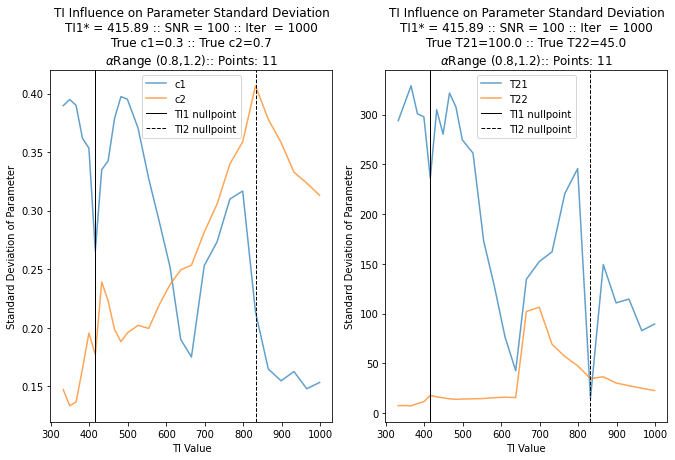

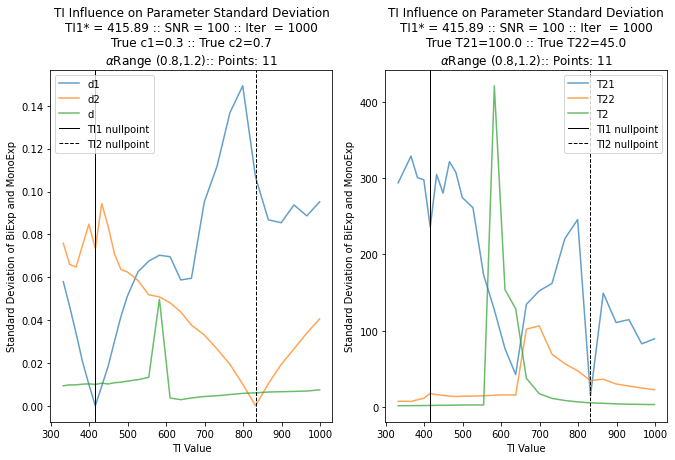

In [ ]:
if stdPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    for i in range(2):
        ax[i].plot(TI_array,stdStore[:,2*i], label = ParamTitle[2*i], alpha = 0.7)
        ax[i].plot(TI_array,stdStore[:,2*i+1], label = ParamTitle[2*i+1], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Standard Deviation of Parameter')
        ax[i].set_title('TI Influence on Parameter Standard Deviation' +
                            '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                            '\nTrue ' + ParamTitle[2*i] + '=' + str(round(realParams[2*i],2)) +
                            ' :: True ' + ParamTitle[2*i+1] + '=' + str(round(realParams[2*i+1],2)) +
                            '\n' + r'$\alpha$'+ 'Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                            '):: Points: ' + str(TI_numPoints))
        ax[i].legend()
    plt.show()

    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)

    for i in range(2):
        ax[i].plot(TI_array,dCoef_std[:,2*i], label = dTitle[2*i], alpha = 0.7)
        ax[i].plot(TI_array,dCoef_std[:,2*i+1], label = dTitle[2*i+1], alpha = 0.7)
        ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Standard Deviation of BiExp and MonoExp')
        ax[i].set_title('TI Influence on Parameter Standard Deviation' +
                            '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                            '\nTrue ' + ParamTitle[2*i] + '=' + str(round(realParams[2*i],2)) +
                            ' :: True ' + ParamTitle[2*i+1] + '=' + str(round(realParams[2*i+1],2)) +
                            '\n' + r'$\alpha$'+ 'Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                            '):: Points: ' + str(TI_numPoints))
        ax[i].legend()
    plt.show()

    # Rely on Variance to calculate distribution
    # for i in range(np.size(ParamTitle)):
    #     plt.plot(TI_array,std2Store[:,i], label = ParamTitle[i])
    # plt.xlabel('TI Value')
    # plt.ylabel('sqrt(var) of Parameter')
    # plt.title('TI Influence on ParameterStandard Deviation')
    # plt.legend()
    # plt.show()

### Condition Number Plots

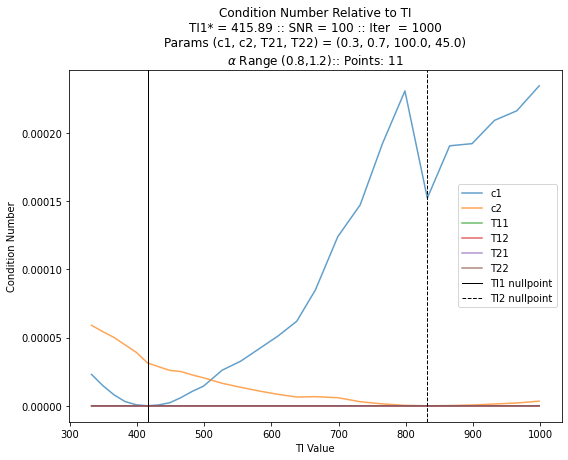

In [ ]:
if cNPlot:
    fig = plt.figure(figsize=(8,6.5), tight_layout=True)
    for elem in range(avgCNStore.shape[1]):
        plt.plot(TI_array,avgCNStore[:,elem], label = AllParamTitle[elem], alpha = 0.7)
    plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
    plt.xlabel('TI Value')
    plt.ylabel('Condition Number')
    plt.title('Condition Number Relative to TI' +
                    '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                    '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
                    '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                    '):: Points: ' + str(TI_numPoints))
    plt.legend()
    plt.tight_layout()
    plt.show()

### Residual Sum of Squares Plot

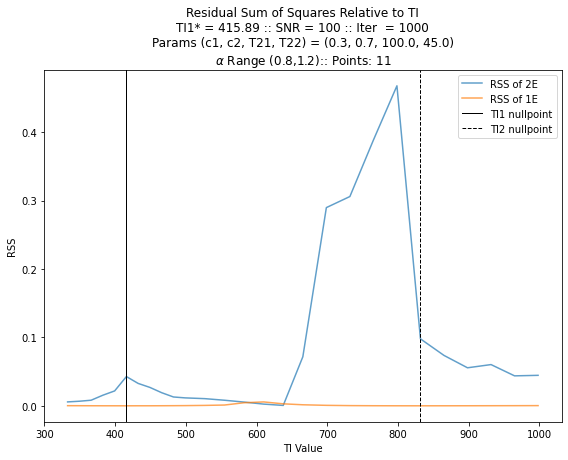

In [ ]:
RSS_avg = np.mean(RSS_Store,axis = 1)
RSS_avg_1E = np.mean(RSS_Store_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,RSS_avg, label = 'RSS of 2E', alpha = 0.7)
plt.plot(TI_array,RSS_avg_1E, label = 'RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Residual Sum of Squares Relative to TI' +
                '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
                '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                '):: Points: ' + str(TI_numPoints))
plt.legend()
plt.tight_layout()
plt.show()

### L2 Norm Plot

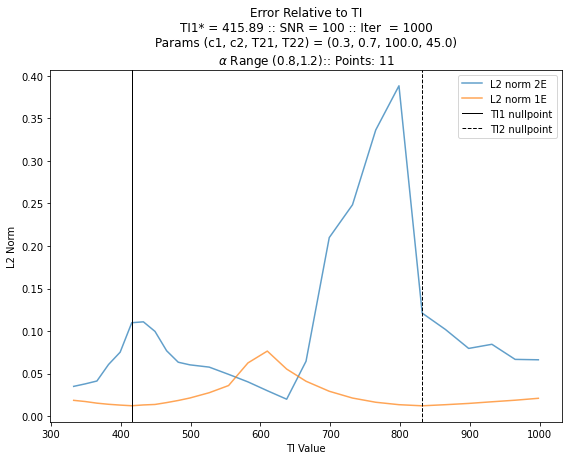

In [ ]:
Err_avg = np.mean(errStore,axis = 1)
Err_avg_1E = np.mean(errStore_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,Err_avg, label = 'L2 norm 2E', alpha = 0.7)
plt.plot(TI_array,Err_avg_1E, label = 'L2 norm 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('L2 Norm')
plt.title('Error Relative to TI' +
                '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
                '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                '):: Points: ' + str(TI_numPoints))
plt.legend()
plt.tight_layout()
plt.show()

### Information Criteria - AIC, BIC, R2, Cp

Text(0, 0.5, 'C_p')

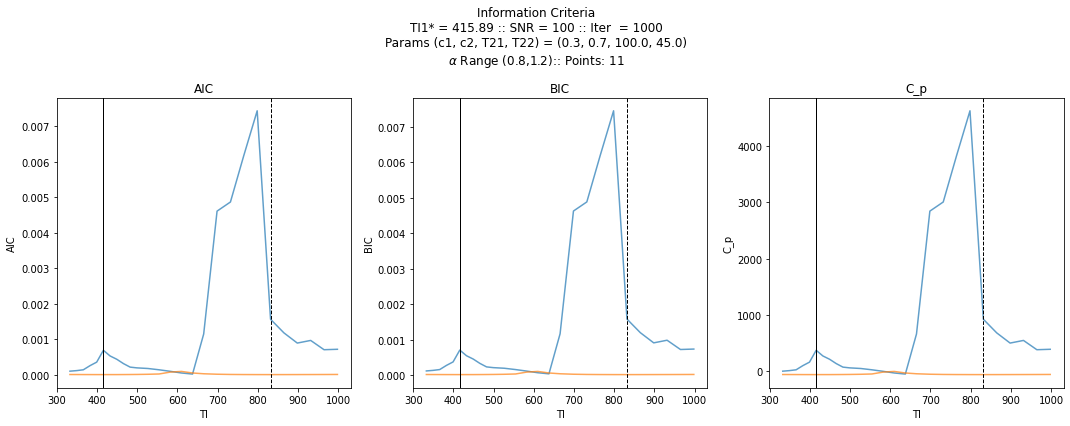

In [ ]:
AIC_2E = 1/tdata.shape[0] * (RSS_avg + 2 * np.size(ParamTitle)*noiseSigma**2)
AIC_1E = 1/tdata.shape[0] * (RSS_avg_1E + 2 * np.size(MonoTitle)*noiseSigma**2)

BIC_2E = 1/tdata.shape[0] * (RSS_avg + np.log(tdata.shape[0]) * np.size(ParamTitle)*noiseSigma**2)
BIC_1E = 1/tdata.shape[0] * (RSS_avg_1E + np.log(tdata.shape[0]) * np.size(MonoTitle)*noiseSigma**2)

Cp_2E = RSS_avg/noiseSigma**2 + 2*np.size(ParamTitle) - tdata.shape[0]
Cp_1E = RSS_avg_1E/noiseSigma**2 + 2*np.size(MonoTitle) - tdata.shape[0]

fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
fig.suptitle('Information Criteria' +
                '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
                '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                '):: Points: ' + str(TI_numPoints))


ax[0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0].set_title('AIC')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('AIC')

ax[1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1].set_title('BIC')
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('BIC')

ax[2].plot(TI_array, Cp_2E, label = 'C_p 2E', alpha = 0.7)
ax[2].plot(TI_array, Cp_1E, label = 'C_p 1E', alpha = 0.7)
ax[2].set_title('C_p')
ax[2].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[2].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[2].set_xlabel('TI')
ax[2].set_ylabel('C_p')


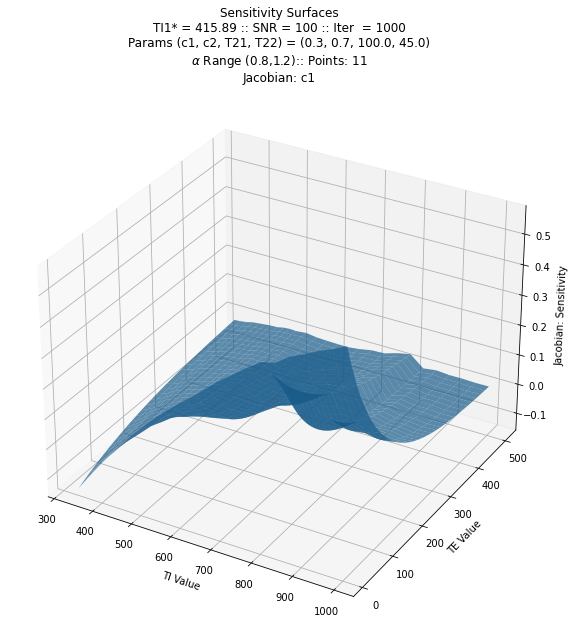

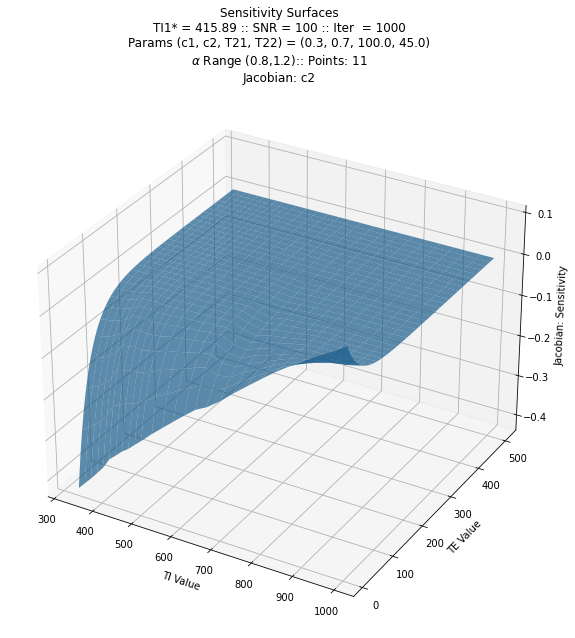

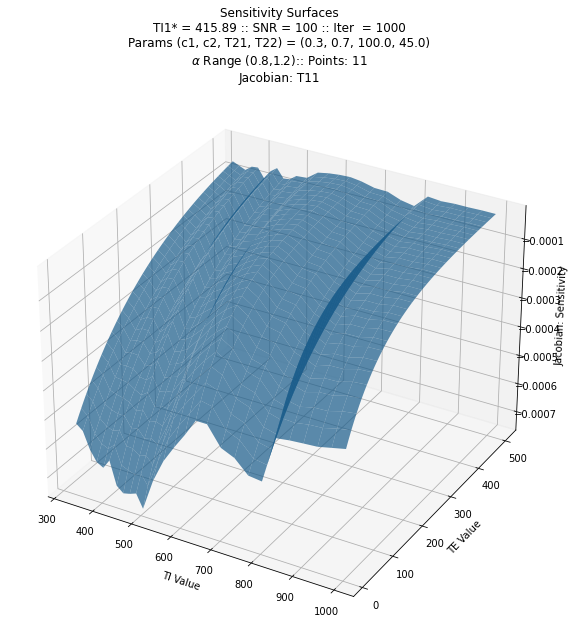

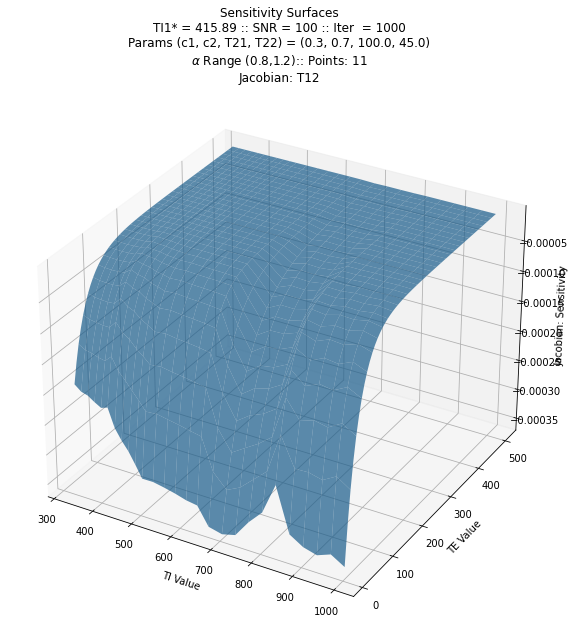

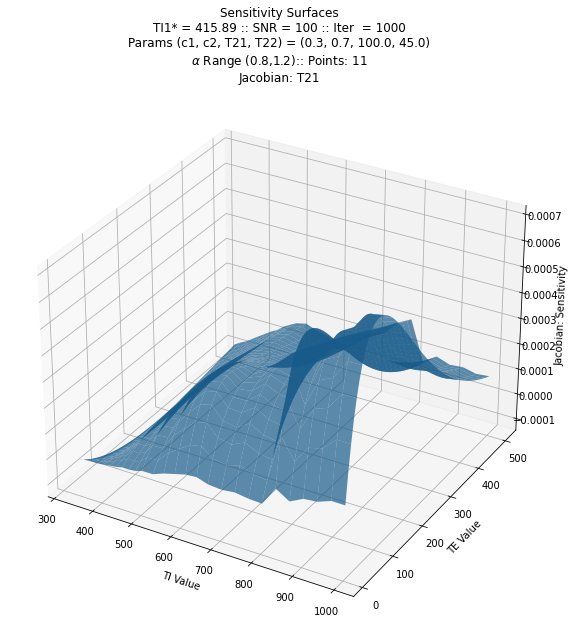

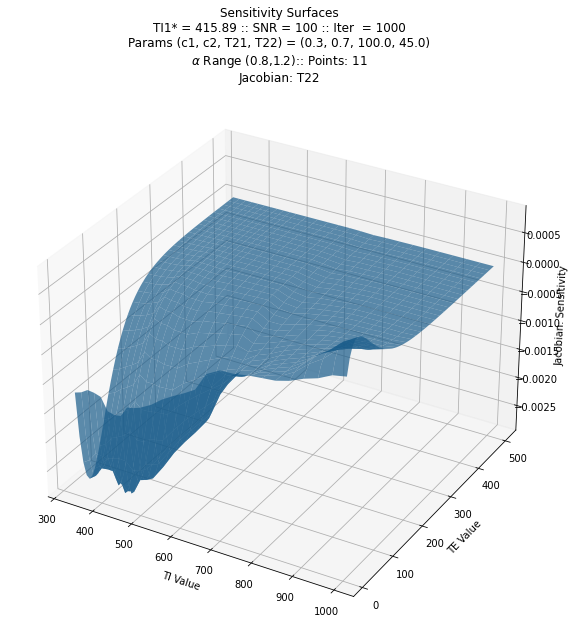

<Figure size 432x288 with 0 Axes>

In [ ]:
TImg,TEmg = np.meshgrid(TI_array,tdata)
Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(AllParamTitle)))
for i in range(Jstore.shape[0]):
    for j in range(Jstore.shape[1]):
        Jstore[i,j,:] = Jacobian_2D(TImg[i,j],TEmg[i,j],T11,T12,*avgPStore[j,:])

round_Params = [round(num, 2) for num in realParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle)

for j in range(Jstore.shape[2]):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    ax.plot_surface(TImg,TEmg,Jstore[:,:,j], alpha = 0.7)
    ax.set_xlabel('TI Value')
    ax.set_ylabel('TE Value')
    ax.set_zlabel('Jacobian: Sensitivity')
    ax.set_title('Sensitivity Surfaces' +
                '\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
                '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
                '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[0]) + "," + str(alpha_array[k]) +
                '):: Points: ' + str(TI_numPoints) +
                '\nJacobian: ' + AllParamTitle[j])
    plt.show()



plt.tight_layout()
plt.show()